Project 1
Experiment with different optimizers and loss functions on mnist dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from time import time

In [3]:
## import dataset
from keras.datasets import mnist

In [4]:
## load and generate date we need in the project
(X_train, y_train), (X_test, y_test) = mnist.load_data()
ind = (y_train==1) | (y_train==7)
X_train = X_train[ind].reshape(-1,28*28)
y_train = y_train[ind].reshape(-1,1) # n-by-1
y_train[y_train==7] = -1
print(X_train.shape,y_train.shape)


(13007, 784) (13007, 1)


In [5]:
ind_t = (y_test==1) | (y_test==7)
X_test = X_test[ind_t].reshape(-1,28*28)
y_test = y_test[ind_t].reshape(-1,1) # n-by-1
y_test[y_test==7] = -1

Stochastic optimizers

In [6]:
## loss functions and gradients

def qloss(I,w,X,y,lam=0.001):
    return np.sum(np.log(1 + np.exp(-myquadratic0(X,y,I,w))))/len(I) + 0.5*lam*np.sum(w*w)

def qlossgrad(I,w,X,y,lam=0.001):
    aux = np.exp(-myquadratic0(X,y,I,w))
    a = -aux/(1+aux)
    X = X[I,:]
    d = X.shape[1]
    d2 = d**2
#     y = y[I]
    ya = y[I]*a
    qterm = X.T.dot((ya.dot(np.ones((1,d))))*X)
    lterm = X.T.dot(ya)
    sterm = np.sum(ya)
    g = np.c_[qterm.reshape(1,-1),lterm.reshape(1,-1),sterm]/len(I) + lam*w # 1 by Dim
    return g.reshape(-1)

def myquadratic0(X,y,I,w):
    X = X[I,:] # n by d
    d = X.shape[1] 
    d2 = d**2 
    y = y[I] # n by 1
    W = w[:d2].reshape((d,d))
    v = w[d2:-1] # d
    b = w[-1]
    qterm = np.einsum('ij,jk,ik->i', X, W, X).reshape(-1,1) # n by 1
    return y*qterm + (y.dot(np.ones((1,d)))*X).dot(v).reshape(-1,1) + y*b


def Res_and_Jac(X,y,w):
    n,d = X.shape
    aux = np.exp(-myquadratic0(X,y,range(n),w))
    r = np.log(1 + aux) # n,1
    # the Jacobian matrix
    a = -aux/(1+aux)
    d2 = d**2 
    ya = y*a # n,1
    qterm = np.zeros((n,d2))
    for k in range(n):
        xk = X[k,:]
        xx = xk.T.dot(xk)
        qterm[k,:] = xx.T
    Y = np.c_[qterm, X, np.ones((n,1))] # n by Dim
    J = Y*(ya.dot(np.ones((1,d2+d+1))))
    return [r,J]


In [7]:
# using svd to realize deduction on data dimensions
def svd(X,d):
    # Compute full SVD
    U, Sigma, Vh = np.linalg.svd(X,full_matrices=False, compute_uv=True)
    # Transform X with SVD components
    X_svd = np.dot(U, np.diag(Sigma))
    return X_svd[:,:d]

Implement gradient methods with PCA d=20 using loss function for quadratic hypersurface with Tikhonov regularization

In [8]:
# svd
d = 20
X = svd(X_train,d)
print(X.shape)

(13007, 20)


In [9]:
X_t = svd(X_test,d)

In [10]:
## find accuracy function
def find_acc(X_test,y_test,w):
    n = X_test.shape[0]
    pred = myquadratic0(X_test,y_test,range(n),w)
    return np.mean(pred>0)

In [11]:
## loss function 
## SGD
def SG(batch_size,redc_type,X=X,y=y_train, N=20, max_iter = 1000):
    if redc_type == 0:
        alpha = 1/(np.arange(1,max_iter+1))
    elif redc_type == 1:
        alpha = 1/(np.arange(1,max_iter+1))**(3/2)
    
    n,d = X.shape
    Dim = d**2 + d + 1
    w = 0.2*np.ones(Dim)
    randn = np.random.randint(n,size=(max_iter,batch_size))
    iter_ = 0
    
    g = qlossgrad(randn[iter_],w,X,y)
    val2 = [qloss(range(n),w,X,y)]
    val_min = val2[0]
    iter_min = iter_
    while iter_ < max_iter-1:
        iter_ += 1
    
        w -= alpha[iter_]*g
        g = qlossgrad(randn[iter_],w,X,y)
        
        # store loss
        val2.append(qloss(range(n),w,X,y))
    
        # keep track of minimal loss 
        if val2[iter_] < val_min:
            val_min = val2[iter_]
            iter_min = iter_
        elif iter_-iter_min > N: # break if falied to improve after N iterations 
            break
            
    return {"F":val2, "var":w, "minF":val_min} 

In [12]:
## Nesterov's accelerated stochastic gradient descend
def NASG(batch_size,redc_type,X=X,y=y_train,d=d,N=100,max_iter = 1000):
    if redc_type == 0:
        alpha = 1/(np.arange(1,max_iter+1))
    elif redc_type == 1:
        alpha = 1/(np.arange(1,max_iter+1))**(3/2)
    
    n,d = X.shape
    Dim = d**2 + d + 1
    w = np.ones(Dim)
    randn = np.random.randint(n,size=(max_iter,batch_size))
    iter_ = 0
    theta = np.ones(Dim)
    g = qlossgrad(randn[iter_],w,X,y)
    val2 = [qloss(range(n),w,X,y)]
    val_min = val2[0]
    iter_min = iter_
    while iter_ < max_iter-1:
        iter_ += 1
        
        # update
        mu = 1 - 3/(5+iter_)
        
        theta_new = w - alpha[iter_]*g
        w = (1+mu)*theta_new - mu*theta
        theta = theta_new.copy()
        
        g = qlossgrad(randn[iter_],w,X,y)
        val2.append(qloss(range(n),w,X,y))
        
        # keep track of minimal loss 
        if val2[iter_] < val_min:
            val_min = val2[iter_]
            iter_min = iter_
        elif iter_-iter_min > N: # break if falied to improve after N iterations 
            break
            
    return {"F":val2, "var":w, "minF":val_min}  

In [13]:
## Adam Stochastic Gradient Descend
def AdamSG(batch_size,b1=0.9,b2=0.999,eps=1e-8,eta=0.001,X=X,y=y_train,N=100,max_iter=1000):
    n,d = X.shape
    Dim = d**2 + d + 1
    w = 0.2*np.ones(Dim)
    m = np.zeros(Dim)
    v = np.zeros(Dim)
    randn = np.random.randint(n,size=(max_iter,batch_size))
    iter_ = 0
    
    g = qlossgrad(randn[iter_],w,X,y)
    val2 = [qloss(range(n),w,X,y)]
    val_min = val2[0]
    iter_min = iter_
    while iter_ < max_iter-1:
        iter_ += 1  
        
        # update
        m = b1*m + (1-b1)*g
        v = b2*v + (1-b2)*(g*g)
        m_hat = m/(1-b1**iter_)
        v_hat = v/(1-b2**iter_)
        w -= eta*m_hat/(np.sqrt(v_hat)+eps)

        g = qlossgrad(randn[iter_],w,X,y)
        val2.append(qloss(range(n),w,X,y))
        
        # keep track of minimal loss 
        if val2[-1] < val_min:
            val_min = val2[-1]
            iter_min = iter_
        elif iter_-iter_min > N: # break if falied to improve after N iterations 
            break
    return {"F":val2, "var":w, "minF":val_min} 

In [14]:
## 
def SLBFGS(alpha,  Ng, Nh, M, m=5, X=X, y=y_train, N=100, epochs=100):
    # m is the limited memory constant in L-BFGS
    # Ng, Nh is the batchsize for gradient and inverse Hessian respectively
    # M, the number of steps between update of inverse Hessian
   
    n,d = X.shape
    Dim = d**2 + d + 1
#     max_iter = epochs * int(n/Ng)
    
    # initialization
    w = 0.2*np.ones(Dim)
    s = np.zeros((Dim,m))
    yy = np.zeros((Dim,m))
    rho = np.ones(Dim)
    iter_ = 0
    
    randg = np.random.randint(n, size=Ng)
    g0 = qlossgrad(randg,w,X,y)
    
    wnew = w - alpha*g0
    randh = np.random.randint(n, size=Nh)
    g = qlossgrad(randh,w,X,y)
    gnew = qlossgrad(randh,wnew,X,y)
    
    s[:,0] = wnew - w
    yy[:,0] = gnew - g
    rho[0] = 1/np.sum(s[:,0]*yy[:,0])
    
    w = wnew.copy()
    gval = [np.linalg.norm(qlossgrad(range(n),w,X,y))]
    fval = [qloss(range(n),w,X,y)]
#     fval_min = fval[-1]
#     iter_min = 0
    while gval[-1]>1e-6:
        iter_ += 1
        
        randg = np.random.randint(n, size=Ng)
        g0 = qlossgrad(randg,w,X,y)
        # direction
        if iter_ < m:
            p = finddirection(g0, s[:,:iter_], yy[:,:iter_], rho[:iter_])### first m zeros
        else:    
            p = finddirection(g0, s, yy, rho)
        
        # update
        step = alpha*p
        wnew = w + step
        
        # update s,yy
        if (iter_+1)%M == 0 or iter_<m-1:
           
            s = np.roll(s,1,axis=1)
            yy = np.roll(yy,1,axis=1)
            rho = np.roll(rho,1)
            s[:,0] = step
            randh = np.random.randint(n, size=Nh)
            g = qlossgrad(randh,w,X,y)
            gnew = qlossgrad(randh,wnew,X,y)
            yy[:,0] = gnew - g
            rho[0] = 1/np.sum(step*yy[:,0])
            
        w = wnew.copy()
        fval.append(qloss(range(n),w,X,y))
        gval.append(np.linalg.norm(qlossgrad(range(n),w,X,y)))
#         if fval[-1] < fval_min:
#             fval_min = fval[-1]
#             w_min = w.copy()
#             iter_min = iter_
#         elif iter_-iter_min > 20:
#             break
    return {'F':fval, 'var':w, 'g':gval, 'iterations':iter_}

def finddirection(g,s,y,rho):
    # g is gradient, d-by-1
    # s is d-by-m (d-d-m) matrix, s[:,i] = x_{k-i+1} - x_{k-i}, m is memory
    # y is d-by-m matrix, y[:,i] = g_{k-i+1} - g_{k-i}
    # rho is 1-by-m matrix, rho[i] = 1/(s[:,i]^T*y[:,i])
    m = s.shape[1]
    a = np.zeros((m,1))
    for i in range(m):
        a[i] = rho[i]*np.sum(s[:,i]*g)
        g -= a[i]*y[:,i]
    gam = np.sum(s[:,0]*y[:,0])/(np.sum(y[:,0]**2)) # scalar
    g = g*gam
    for j in range(m-1,-1,-1):
        aux = rho[j]*np.sum(y[:,j]*g)
        g += (a[j]-aux)*s[:,j]
    return -g
    

<ipython-input-6-49fbfe37e01f>:4: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-myquadratic0(X,y,I,w))))/len(I) + 0.5*lam*np.sum(w*w)
<ipython-input-6-49fbfe37e01f>:7: RuntimeWarning: overflow encountered in exp
  aux = np.exp(-myquadratic0(X,y,I,w))
<ipython-input-6-49fbfe37e01f>:8: RuntimeWarning: invalid value encountered in true_divide
  a = -aux/(1+aux)


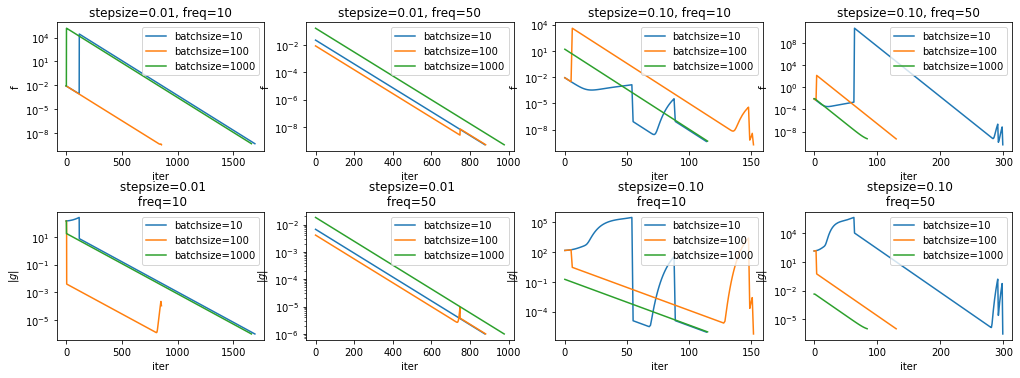

In [17]:
# alpha, m, Ng, Nh, M
alps = [0.01,0.1]
bszs = [[10,10],[100,100],[1000,1000]]
Ms = [10,50]
Fmin = 100
Fs = np.zeros((2,3,2))
allFs = []
gs = np.zeros((2,3,2))
allgs = []
iterations = np.zeros((2,3,2))
times = np.zeros((2,3,2))
accs = np.zeros((2,3,2))

fig,ax = plt.subplots(2,4,figsize=(14,5))
fig.tight_layout(h_pad=4)
its = 0
for i in range(len(alps)):
    alpha = alps[i]
    for k in range(len(Ms)):
        M = Ms[k]
        for j in range(len(bszs)):
            Ng,Nh = bszs[j]
            
            tt = time() # time count
            res = SLBFGS(alpha,Ng,Nh,M)
            times[i,j,k] = time()-tt # time count
            Fs[i,j,k] = res['F'][-1]
            gs[i,j,k] = res['g'][-1]
            accs[i,j,k] = find_acc(X_t,y_test,res['var'])
            iterations[i,j,k] = res['iterations']
            allFs.append(res['F'])
            allgs.append(res['g'])
            # plot 
            ax[0,its].semilogy(res['F'], label='batchsize=%d'%Ng)
            ax[1,its].semilogy(res['g'], label='batchsize=%d'%Ng)
            
            # store optimal
            if res['F'][-1] < Fmin:
                fval = res['F']
                Fmin = fval[-1]
                amin = alpha
                Ngmin = Ng
                Nhmin = Nh
                Mmin = M
        ax[0,its].set_xlabel('iter')
        ax[0,its].set_ylabel('f')
        ax[0,its].legend()
#         ax[0,its].set_ylim(0,1)
        ax[0,its].set_title('stepsize=%.2f'%alpha+', freq=%d'%M)
        ax[1,its].set_xlabel('iter')
        ax[1,its].set_ylabel('$\|g\|$')
        ax[1,its].legend()
#         ax[1,its].set_ylim(0,10)
        ax[1,its].set_title('\n stepsize=%.2f'%alpha+'\n freq=%d'%M)
        its += 1     
plt.show()

In [19]:
print('loss function:\n', Fs)
print('grad norm:\n', gs)
print('accuracy:\n', accs)
print('times:\n',times)
print('iterations:\n',iterations)

loss function:
 [[[4.94626654e-10 4.93660294e-10]
  [           inf 4.94291275e-10]
  [4.98211965e-10 4.90110783e-10]]

 [[4.31133178e-10 3.89156519e-11]
  [1.79581607e-10 4.53094244e-10]
  [4.68066524e-10 4.86347060e-10]]]
grad norm:
 [[[9.94612140e-07 9.93602333e-07]
  [           nan 9.94274819e-07]
  [9.98182735e-07 9.90058650e-07]]

 [[9.28582823e-07 2.78982110e-07]
  [5.99292865e-07 9.77157444e-07]
  [9.67509748e-07 9.86232069e-07]]]
accuracy:
 [[[1.         1.        ]
  [0.99815072 1.        ]
  [1.         1.        ]]

 [[1.         1.        ]
  [1.         1.        ]
  [1.         1.        ]]]
times:
 [[[133.32736921  71.86355162]
  [ 64.67945433  74.11257291]
  [139.73534131  77.75030351]]

 [[  8.75038123  24.50822926]
  [ 11.86199331   9.86574554]
  [  8.69477034   6.39726138]]]
iterations:
 [[[1692.  877.]
  [ 855.  881.]
  [1661.  977.]]

 [[ 114.  299.]
  [ 152.  130.]
  [ 115.   84.]]]


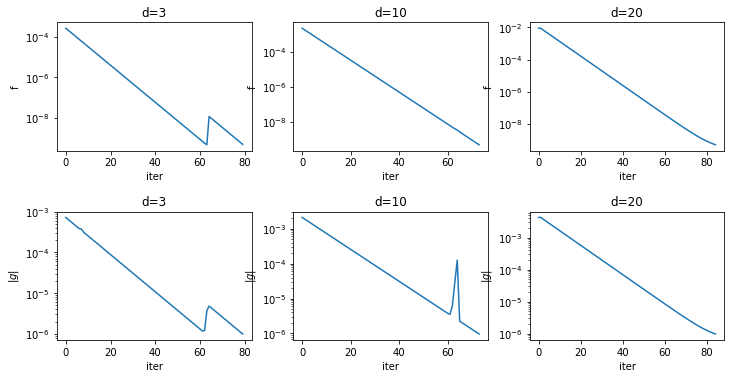

loss function:
 [4.87888182e-10 4.66013783e-10]
grad norm:
 [9.87813932e-07 9.65415734e-07]
accuracy:
 [1. 1.]
times:
 [2.76458979 3.77746177]
iterations:
 [79. 73.]


In [34]:
MFs = np.zeros(2)
Mgs = np.zeros(2)
Miterations = np.zeros(2)
Mtimes = np.zeros(2)
Maccs = np.zeros(2)

fig, ax = plt.subplots(2,3,figsize=(10,5))
fig.tight_layout(h_pad=4)

for i in range(2):
    d = [3,10][i]
    X_d = svd(X_train,d)
    tt = time()
    ress = SLBFGS(0.1,1000,1000,50,X=X_d)
    Mtimes[i] = time()-tt # time count
    MFs[i] = ress['F'][-1]
    Mgs[i] = ress['g'][-1]
    Maccs[i] = find_acc(svd(X_test,d),y_test,ress['var'])
    Miterations[i] = ress['iterations']
    ax[0,i].semilogy(ress['F'])
    ax[1,i].semilogy(ress['g']) 
    ax[0,i].set_xlabel('iter')
    ax[0,i].set_ylabel('f')
    ax[0,i].set_title('d=%d'%d)
    ax[1,i].set_xlabel('iter')
    ax[1,i].set_ylabel('$\|g\|$')
    ax[1,i].set_title('d=%d'%d)
ax[0,2].semilogy(allFs[-1])
ax[1,2].semilogy(allgs[-1])
ax[0,2].set_xlabel('iter')
ax[0,2].set_ylabel('f')
ax[0,2].set_title('d=20')
ax[1,2].set_xlabel('iter')
ax[1,2].set_ylabel('$\|g\|$')
ax[1,2].set_title('d=20')

plt.show()
print('loss function:\n', MFs)
print('grad norm:\n', Mgs)
print('accuracy:\n', Maccs)
print('times:\n',Mtimes)
print('iterations:\n',Miterations)

In [31]:
# fig,ax = plt.subplots(2,4,figsize=(14,5))
# fig.tight_layout(h_pad=4)
# its = 0
# itss = 0
# for i in range(len(alps)):
#     alpha = alps[i]
#     for k in range(len(Ms)):
#         M = Ms[k]
#         for j in range(len(bszs)):
#             Ng,Nh = bszs[j]
#             FF = allFs[itss]
#             gg = allgs[itss]
#             ax[0,its].semilogy(FF, label='batchsize=%d'%Ng)
#             ax[1,its].semilogy(gg, label='batchsize=%d'%Ng)
#             itss += 1
#         ax[0,its].set_xlabel('iter')
#         ax[0,its].set_ylabel('f')
#         ax[0,its].legend()
# #         ax[0,its].set_ylim(0,1)
#         ax[0,its].set_title('stepsize=%.2f'%alpha+', freq=%d'%M)
#         ax[1,its].set_xlabel('iter')
#         ax[1,its].set_ylabel('$\|g\|$')
#         ax[1,its].legend()
# #         ax[1,its].set_ylim(0,10)
#         ax[1,its].set_title('stepsize=%.2f'%alpha+', freq=%d'%M)
#         its += 1 
# plt.show()

Experiments with nonlinear least squares solvers

In [15]:
# L-M
def LM(Rmax, eta=0.1, X=X,y=y_train,iter_max=1000):
    d = X.shape[1] 
    num_w = d**2 + d + 1
    iter_ = 0 
             
    R = 0.2*Rmax
    w = np.zeros(num_w)
    while iter_ < iter_max-1:
        print(iter_)
        iter_ += 1
        res, J = Res_and_Jac(X,y,w)
        B = J.T.dot(J) + (1e-6)*np.eye(num_w) # Dim by Dim
        g = J.T.dot(res) # Dim by 1
        pstar = -np.linalg.lstsq(B,g,rcond=None)[0]
        if np.linalg.norm(pstar) <= R:
            p = pstar.copy() # Dim by 1
            nor_p = np.linalg.norm(p)
        else: 
            lam = 1 # initial guess for lambda
            while 1:
                B1 = B + lam*np.eye(num_w)
                C = np.linalg.cholesky(B1)
                p = -np.linalg.inv(C).dot(np.linalg.inv(C.T)).dot(g) # solve B1*p = -g
                nor_p = np.linalg.norm(p)
                dd = np.absolute(nor_p - R) # R is the trust region radius
                if dd < 1e-6:
                    break
                q = np.linalg.inv(C.T).dot(p) # solve C^\top q = p
                nor_q = np.linalg.norm(q)
                lamnew = lam + ((nor_p/nor_q)**2)*(nor_p - R)/R
                if lamnew < 0:
                    lam = 0.5*lam
                else:
                    lam = lamnew
#         m = myquadratic(X,y,w) + np.dot(p,g) + p.dot(B).dot(p.T)/2
        resnew = Res_and_Jac(X,y,w+p.reshape(-1))[0]
        rho = (np.sum(res**2)/2 - np.sum(resnew**2)/2)/(p.T.dot(g) + p.T.dot(B).dot(p)/2)
        if rho < 1/4:
            R = R/4
        elif rho > 3/4 and nor_p==R:
            R = min([2*R, Rmax])
        if rho > eta:
            w += p.reshape(-1)
                    
        if (np.sum(p**2) <= 1e-6 or rho>0):
            break                                  
    return w


In [16]:
def GN(eps=1e-4,iter_max=1e4):
    d = X.shape[1] 
    num_w = d**2 + d + 1 #the number of params
    iter_ = 0 #set the init iter count is 0
    
    w = 0.5 * np.ones((1,num_w))
    while iter_ < iter_max:
        iter_ += 1
            
        B = J.T.dot(J) + (1e-6)*np.eye(num_w)
        g = J.T.dot(res)
        p = -np.linalg.inv(B).dot(g) # unconstrained minimizer
        w += p
                    
        if (np.sum(p**2) <= eps):
            break 
    return w

Experiment methods with different settings

Thanks.